# Machine Learning Engineer Nanodegree - Capstone Project

The solution to the Kaggle Challenge [LANL Earthquake Prediction](https://www.kaggle.com/c/LANL-Earthquake-Prediction) as part of the Capstone project for the Machine Learning Engineer.

This notebook contains the code to solve the problem as well as several visualizations to display the data better. In this project machine learning algorithms from Scikit were used as well as Keras to solve the problem with a neural network.


## Instructions

Follow the instructions in the [README Data](https://github.com/tobiassteidle/MLND_Capstone/tree/master/data) to download the training and test data for the project.

##### Additional Python scripts:  
utils.py: Help functions for reading files or processing the data  
visualize.py: Functions for Plotting Data

All cells can be executed one after the other. At the end, a sumbission.csv file is created which can be transferred to Kaggle to solve the project.

## Implementation

#### Import dependencies and set common constants

In [1]:
import os
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm_notebook as tqdm
from visualize import *
from utils import *
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
from tensorflow import set_random_seed

train_data_file = './data/train.csv'
test_file_dir = './data/test/'
submission_file = './submission.csv'

CHUNK_SIZE = 150000
SUBSET_SIZE = 60000000

n_mfcc=10 # Anzahl der MFCC Features

seed = 1234
np.random.seed(seed)
set_random_seed(seed)

#### Load the data from the CSV

In [2]:
seismic_data  = pd.read_csv(train_data_file, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

acoustic_data = seismic_data.acoustic_data.values.astype('float32')
time_to_failure = seismic_data.time_to_failure.values.astype('float64')

## Data Exploration

#### Number of records + example of top 5 data

In [3]:
print("Total rows in dataset: %d" % len(seismic_data)) 
print("Top 5 rows:")
seismic_data.head(5)

Total rows in dataset: 629145480
Top 5 rows:


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


#### Visualization of a chunk of the acoustic data with corresponding time_to_failure

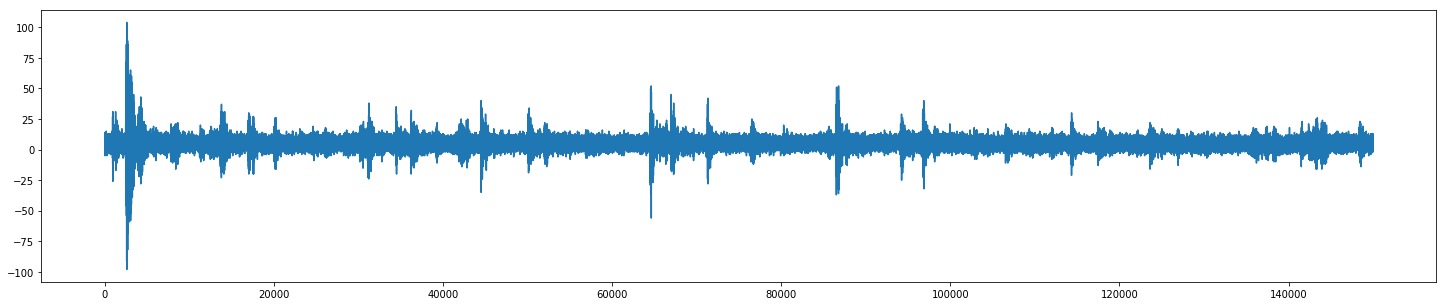

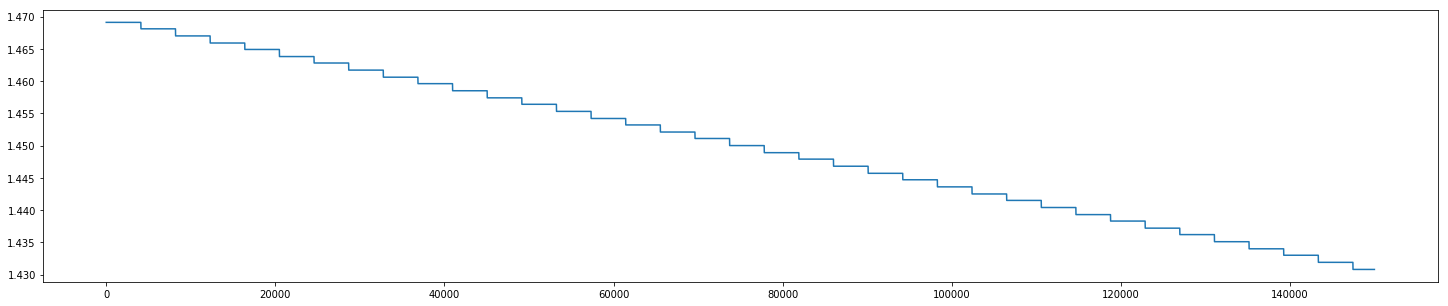

In [4]:
plot_dataset(acoustic_data[:CHUNK_SIZE])
plot_dataset(time_to_failure[:CHUNK_SIZE])

#### MFCC Features

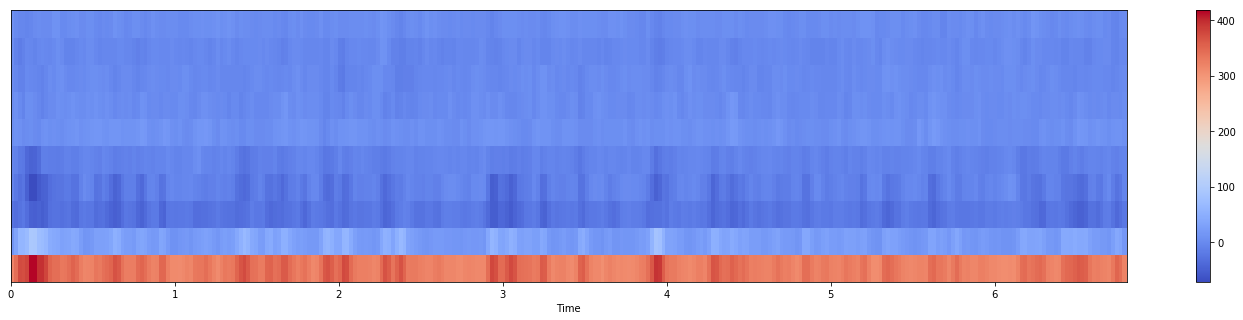

In [5]:
plot_mfcc(librosa.feature.mfcc(acoustic_data[:CHUNK_SIZE], n_mfcc=n_mfcc))

Splitten der gesamten Daten in Chunks von 150000 Datensätzen größe. Erstellen eines Dataframes mit den einzelnen MFCC features + time_to_failure.

In [6]:
import librosa, librosa.display

data_chunks = list(chunks(seismic_data, n=CHUNK_SIZE))
    
mfcc_ttf_map = {}    
for chunk in data_chunks:
    mfcc_chunk = librosa.feature.mfcc(chunk.acoustic_data.values.astype('float32'), n_mfcc=n_mfcc)
    mfcc_chunk_mean = mfcc_chunk.mean(axis=1)    
    
    for i, each_mfcc_mean in enumerate(mfcc_chunk_mean):    
        key = 'mfcc_{}'.format(i)
        if key not in mfcc_ttf_map:
            mfcc_ttf_map[key] = []
        mfcc_ttf_map[key].append(each_mfcc_mean)

    key = 'time_to_failure'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []        
    mfcc_ttf_map[key].append(chunk.time_to_failure.iloc[-1])
        
mfcc_ttf_df = pd.DataFrame(mfcc_ttf_map)

Plotten der einzelnen MFCC Features mit der time_to_failure Line um die realation der MFCC Features zum Zeitlichen Ereignisses zu sehen.

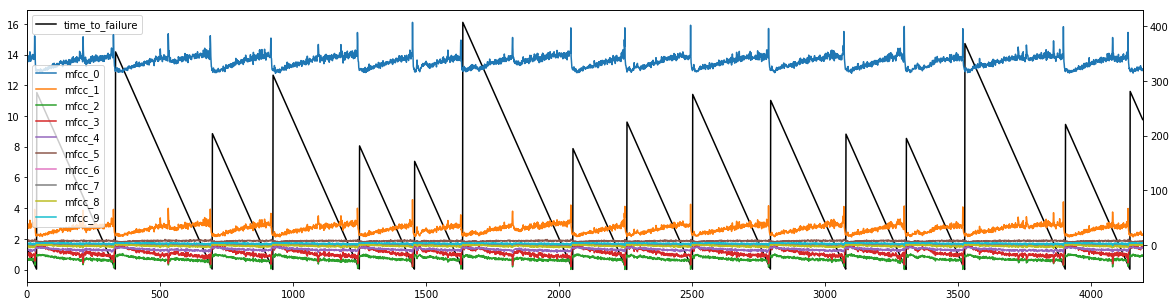

In [7]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)
plt.show()

Wie man an diesem Diagramm sehen kann gibts es zwischen den Peaks mancher MFCC Features eine klare Relation zum auftreten des Erdbebens.

#### Do PCA

Reduzieren der MFCC Features per PCA auf aktuell nur noch ein einziges Feature.

In [8]:
from sklearn.decomposition import PCA

mfcc_data = mfcc_ttf_df.drop(['time_to_failure'], axis=1)

pca = PCA(n_components=6, svd_solver='full', whiten=False).fit(mfcc_data)
reduced_data = pca.transform(mfcc_data)

reduced_data_frame = pd.DataFrame(reduced_data)
reduced_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

#### After PCA

Plotten des durch das PCA erstellte Feature im Vergleich zum Timeline des Erdbebens. Das Signal wurde zusätzlich noch durch einen Savgol Filter geglättet, damit die Daten nicht so massiv osszilieren.

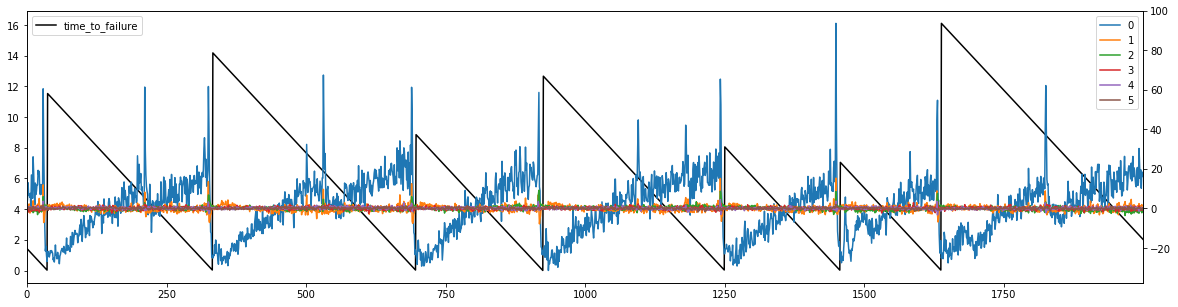

In [9]:
import scipy
from scipy.signal import savgol_filter

fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

from sklearn import preprocessing
from scipy import stats

data = reduced_data_frame.drop(['time_to_failure'], axis=1)



xx = data

#yhat = savgol_filter(np.ravel(xx.values), 55, 3)
#yhat = savgol_filter(yhat, 255, 3)
#xx = pd.DataFrame(reject_outliers(yhat))

#xx = pd.DataFrame(yhat)
#xx = pd.DataFrame(reject_outliers(yhat))

#data = reject_outliers(data)

reduced_data_frame['time_to_failure'][:2000].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
#reduced_data_frame.drop(['time_to_failure'], axis=1)[:1000].plot(ax=ax2, legend=True)
xx[:2000].plot(ax=ax2, legend=True)
plt.show()

Erstellen der Trainingsdaten mit dem neuen Feature.

In [10]:
preprocessed_data_frame = pd.DataFrame(xx)
preprocessed_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

### Visualize Testfiles

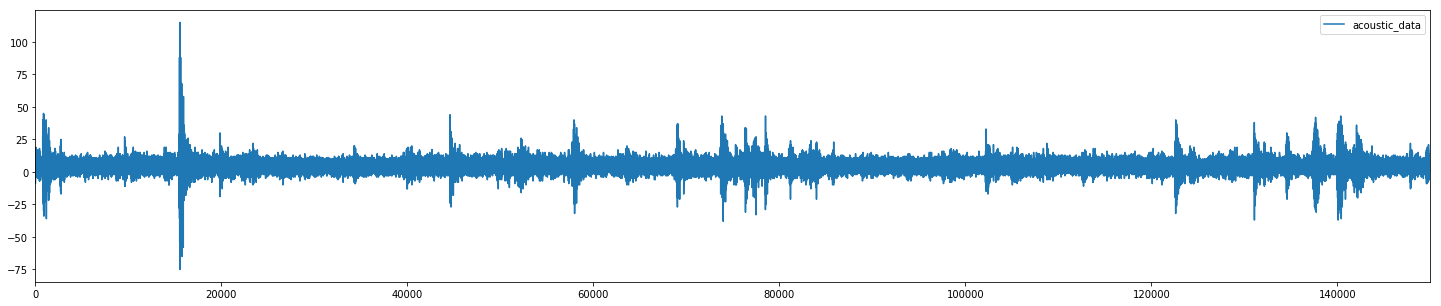

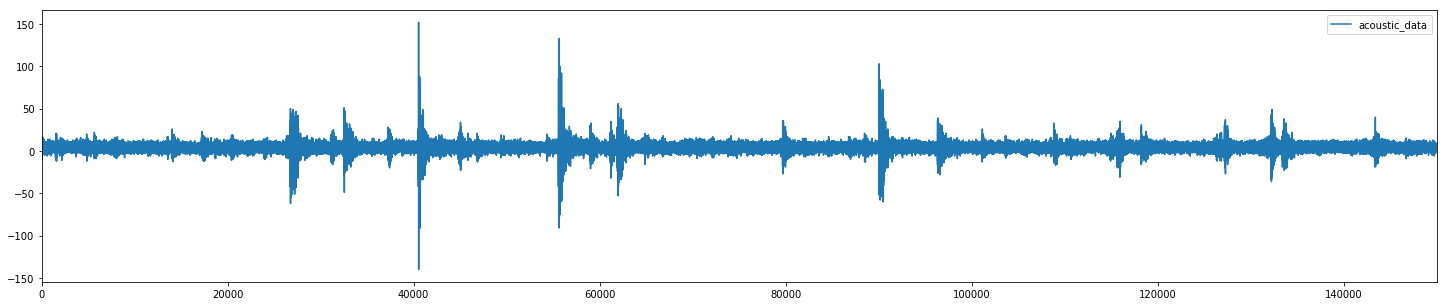

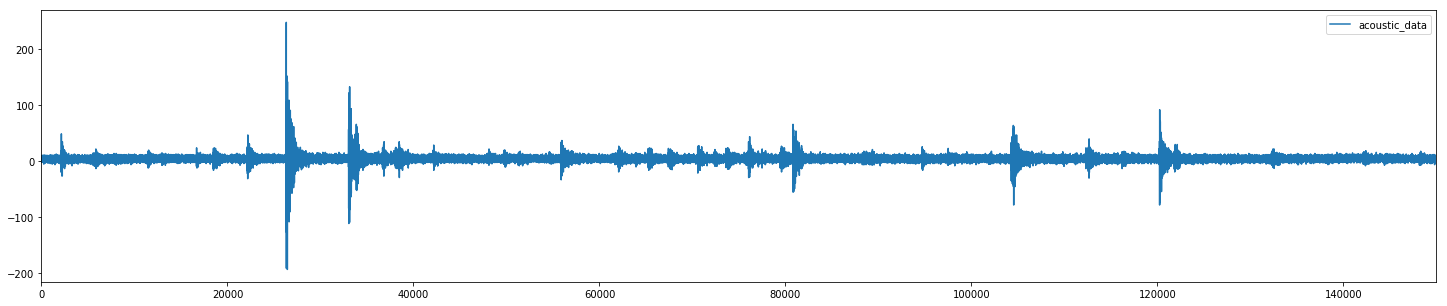

In [11]:
plot_testfile(test_file_dir, n_samples=3)


In [12]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import cross_val_score

#def report_cv(model):
#    X = preprocessed_data_frame.drop(['time_to_failure'], axis=1).values
#    y = preprocessed_data_frame['time_to_failure'].values
#    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=10)
#    print('Cross Validation scores: {}'.format(abs(scores)))
#    print('Average score: {}'.format(abs(scores.mean())))

#report_cv(RandomForestRegressor(max_depth=5, random_state=60, n_estimators=100,n_jobs = -1, min_samples_leaf= 30))

## Train / Test split

In [13]:
from sklearn.model_selection import train_test_split

#X = mfcc_ttf_df.drop(['time_to_failure'], axis=1).values
#y = mfcc_ttf_df['time_to_failure'].values

#X = reduced_data_frame.drop(['time_to_failure'], axis=1).values
#y = reduced_data_frame['time_to_failure'].values

X = preprocessed_data_frame.drop(['time_to_failure'], axis=1).values
y = preprocessed_data_frame['time_to_failure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Benchmark

Methode um den Score zu printen.

In [14]:
def print_scores(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)    
    print('Cross Validation scores: {}'.format(abs(scores)))
    print('Average score: {}'.format(abs(scores.mean())))

In [15]:
def print_mean_absolute_error(model):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print('Average score (MAE): {}'.format(mae))

Verwenden ein K-Nearest Neighbor um einen Referenze-/Benchmark Score zu erhalten.

In [16]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 14)
knn.fit(X_train, y_train)

print_scores(knn, X_test, y_test)
print_mean_absolute_error(knn)

Cross Validation scores: [2.10163591 2.07821666 2.0723906  2.18771408 1.98902846]
Average score: 2.0857971400027884
Average score (MAE): 2.048374616677804


## Data Preprocessing

Methode zum Vorverarbeiten der Daten die aus den Testfiles gelesen werden. Diese Methode soll sicher stellen das die Input Daten für das finale Model auch dem Datenformat entsprechen das auch trainiert wurde.

#### ACHTUNG: HIER FEHLT NOCH DIE SIGNALGLÄTTUNG

In [17]:
def extract_features(seismic_data):
    mfcc = librosa.feature.mfcc(seismic_data, n_mfcc=n_mfcc)    
    mfcc_mean = mfcc.mean(axis=1)
    
    feature_map = {}
    
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'f{}'.format(i)
        if key not in feature_map:
            feature_map[key] = []
        feature_map[key].append(each_mfcc_mean)    
    
    reduced = pca.transform(pd.DataFrame(feature_map))        
    return reduced

## Implementation

In [18]:
#Xgboost example
#https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

#LightGBM examp1le
#https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

Methode zum schreiben der Submission File für die Übertragung an Kaggle.

In [27]:
def write_submission(output_file, model, isRNN=False):
    test_files = resolve_csv_files(test_file_dir)    
    
    with open(output_file, 'w', newline='') as outcsv:
        writer = csv.DictWriter(outcsv, fieldnames = ['seg_id', 'time_to_failure'])
        writer.writeheader()
        
        for file in tqdm(test_files[:10]):
            seismic_test_data  = pd.read_csv(file, dtype={'acoustic_data': np.float32})
            features = extract_features(seismic_test_data.acoustic_data.values.astype('float32')) 
            if isRNN:
                features = np.reshape(features, (features.shape[0], 1, features.shape[1]))
            
            prediction = model.predict(features)[0]
            
            if isRNN:
                prediction = prediction[0]
            
            writer.writerow({'seg_id': stem_filename(file), 'time_to_failure': prediction})

In [20]:

write_submission(submission_file, knn)

Erstellen einer Pipeline mit mehreren Machine Learning Algorithmen und einer Reihe von dazugehörigen Parametern über die per RandomizedSearchCV das beste Model ermittelt werden soll.

In [21]:
from sklearn import pipeline, metrics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# set up pipeline
est = pipeline.Pipeline([
        ('xgb', XGBRegressor(silent=True)),
   #     ('rfr', RandomForestRegressor(n_estimators=18, random_state=3, max_depth=3,
   #                                     min_weight_fraction_leaf=0.1,max_leaf_nodes = 20,
   #                                    min_samples_split = 20)),
])



# Paramter die versuchet werden sollen. Der Parameter hat immer einen Prefix ${Name des Algorithmus in der Pipeline z.B. 'xbg'}
# gefolgt von 2x underscore und dann nen eigentlichen Namen des Parameters.

params = {
    'xgb__learning_rate': [0.003, 0.005, 0.01, 0.05, 0.1],
    'xgb__min_child_weight': [5, 6, 7, 8, 9, 10, 11, 12],
    'xgb__subsample': [0.5, 0.7, 0.9],
    'xgb__colsample_bytree': [0.5, 0.7, 0.9],
    'xgb__max_depth': [1, 3, 5, 7, 9, 11],
    'xgb__n_estimators': [10, 50, 100, 150],
    
    #'rfr__bootstrap': [True, False],
    #'rfr__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    #'rfr__max_features': ['auto', 'sqrt'],
    #'rfr__min_samples_leaf': [1, 2, 4],
    #'rfr__min_samples_split': [2, 5, 10],
    #'rfr__n_estimators': [130, 180, 230]
}

#cv_sets = ShuffleSplit(n_splits=50, test_size=0.2, random_state=seed) # dauert sehr lange
cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=seed)

search = RandomizedSearchCV(estimator=est, 
                            param_distributions=params, scoring='neg_mean_absolute_error', random_state=seed, 
                            #n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)
                            n_iter=100, cv=cv_sets, verbose=1, n_jobs=1, return_train_score=True)
                            

search.fit(X_train, y_train)

print(search.best_estimator_)

# to prevent stange prediction bug - save and reload model: https://github.com/dmlc/xgboost/issues/1238
#TEMP_MODEL = 'tmp_xgbregressor.mdl'
#search.best_estimator_.save_model(TEMP_MODEL)
#search.best_estimator_.load_model(TEMP_MODEL)
#os.remove(TEMP_MODEL)

print_scores(search.best_estimator_, X_test, y_test)
print_mean_absolute_error(search.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  5.4min finished


Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))])
Cross Validation scores: [2.10236009 1.92454441 2.1646903  2.19462973 1.9185942 ]
Average score: 2.060963746261212
Average score (MAE): 2.0299615743032575


In [22]:
#Average score: 2.184982829934742
#Average score (MAE): 2.1759349740375638

In [23]:
write_submission(submission_file, search.best_estimator_)


One option for a smarter implementation of hyperparameter tuning is to combine random search and grid search:

Use random search with a large hyperparameter grid
Use the results of random search to build a focused hyperparameter grid around the best performing hyperparameter values.
Run grid search on the reduced hyperparameter grid.
Repeat grid search on more focused grids until maximum computational/time budget is exceeded.
Or could even look into using hyperopt. Here might be a good example of how to use this bayesian optimization technique in python.

https://github.com/hyperopt/hyperopt  
https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
import time

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(None,6)))
model.add(GaussianNoise(0.2))
model.add(Dropout(0.4))
model.add(LSTM(32))
model.add(GaussianNoise(0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))

#optimizer = Adam(lr=0.0001)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimizer = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])
             
now = time.strftime("%Y%m%d_%H%M%S")    
tensorboard_callback = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)    


model.fit(X_train_reshape, y_train,
              epochs=200,
              batch_size=128,
              validation_split=0.05,
              #validation_split=0.2,
              verbose=1,
              callbacks=[tensorboard_callback]
            )
              
#print(model.summary())
score = model.evaluate(X_test_reshape, y_test, batch_size=128)

Using TensorFlow backend.


Train on 3188 samples, validate on 168 samples
Epoch 1/200
3188/3188 [==============================] - ETA: 26s - loss: 5.7677 - mean_absolute_error: 5.76 - ETA: 3s - loss: 5.6326 - mean_absolute_error: 5.6326 - ETA: 1s - loss: 5.5014 - mean_absolute_error: 5.501 - ETA: 0s - loss: 5.5065 - mean_absolute_error: 5.506 - ETA: 0s - loss: 5.5191 - mean_absolute_error: 5.519 - 1s 465us/step - loss: 5.4877 - mean_absolute_error: 5.4877 - val_loss: 5.1566 - val_mean_absolute_error: 5.1566
Epoch 2/200
3188/3188 [==============================] - ETA: 0s - loss: 5.4736 - mean_absolute_error: 5.473 - ETA: 0s - loss: 5.2446 - mean_absolute_error: 5.244 - ETA: 0s - loss: 5.2019 - mean_absolute_error: 5.201 - ETA: 0s - loss: 5.1536 - mean_absolute_error: 5.153 - ETA: 0s - loss: 5.0797 - mean_absolute_error: 5.079 - 0s 95us/step - loss: 5.0428 - mean_absolute_error: 5.0428 - val_loss: 4.6831 - val_mean_absolute_error: 4.6831
Epoch 3/200
3188/3188 [==============================] - ETA: 0s - loss: 4.

3188/3188 [==============================] - ETA: 0s - loss: 2.2785 - mean_absolute_error: 2.278 - ETA: 0s - loss: 2.3239 - mean_absolute_error: 2.323 - ETA: 0s - loss: 2.3166 - mean_absolute_error: 2.316 - ETA: 0s - loss: 2.2791 - mean_absolute_error: 2.279 - ETA: 0s - loss: 2.2691 - mean_absolute_error: 2.269 - 0s 96us/step - loss: 2.2398 - mean_absolute_error: 2.2398 - val_loss: 2.2218 - val_mean_absolute_error: 2.2218
Epoch 19/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2314 - mean_absolute_error: 2.231 - ETA: 0s - loss: 2.2311 - mean_absolute_error: 2.231 - ETA: 0s - loss: 2.1871 - mean_absolute_error: 2.187 - ETA: 0s - loss: 2.2171 - mean_absolute_error: 2.217 - ETA: 0s - loss: 2.2032 - mean_absolute_error: 2.203 - 0s 94us/step - loss: 2.2187 - mean_absolute_error: 2.2187 - val_loss: 2.2136 - val_mean_absolute_error: 2.2136
Epoch 20/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2827 - mean_absolute_error: 2.282 - ETA: 0s - loss: 2.1992 

3188/3188 [==============================] - ETA: 0s - loss: 2.0202 - mean_absolute_error: 2.020 - ETA: 0s - loss: 2.1279 - mean_absolute_error: 2.127 - ETA: 0s - loss: 2.1195 - mean_absolute_error: 2.119 - ETA: 0s - loss: 2.1800 - mean_absolute_error: 2.180 - ETA: 0s - loss: 2.1614 - mean_absolute_error: 2.161 - 0s 94us/step - loss: 2.1745 - mean_absolute_error: 2.1745 - val_loss: 2.1518 - val_mean_absolute_error: 2.1518
Epoch 36/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2815 - mean_absolute_error: 2.281 - ETA: 0s - loss: 2.1634 - mean_absolute_error: 2.163 - ETA: 0s - loss: 2.1934 - mean_absolute_error: 2.193 - ETA: 0s - loss: 2.1825 - mean_absolute_error: 2.182 - ETA: 0s - loss: 2.2075 - mean_absolute_error: 2.207 - 0s 92us/step - loss: 2.1833 - mean_absolute_error: 2.1833 - val_loss: 2.1509 - val_mean_absolute_error: 2.1509
Epoch 37/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1213 - mean_absolute_error: 2.121 - ETA: 0s - loss: 2.1145 

Epoch 53/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0710 - mean_absolute_error: 2.071 - ETA: 0s - loss: 2.0757 - mean_absolute_error: 2.075 - ETA: 0s - loss: 2.1273 - mean_absolute_error: 2.127 - ETA: 0s - loss: 2.1486 - mean_absolute_error: 2.148 - ETA: 0s - loss: 2.1609 - mean_absolute_error: 2.160 - ETA: 0s - loss: 2.1728 - mean_absolute_error: 2.172 - 0s 102us/step - loss: 2.1644 - mean_absolute_error: 2.1644 - val_loss: 2.1114 - val_mean_absolute_error: 2.1114
Epoch 54/200
3188/3188 [==============================] - ETA: 0s - loss: 2.3056 - mean_absolute_error: 2.305 - ETA: 0s - loss: 2.1265 - mean_absolute_error: 2.126 - ETA: 0s - loss: 2.1407 - mean_absolute_error: 2.140 - ETA: 0s - loss: 2.1376 - mean_absolute_error: 2.137 - ETA: 0s - loss: 2.1675 - mean_absolute_error: 2.167 - 0s 94us/step - loss: 2.1757 - mean_absolute_error: 2.1757 - val_loss: 2.1101 - val_mean_absolute_error: 2.1101
Epoch 55/200
3188/3188 [==============================] - ETA: 0s -

3188/3188 [==============================] - ETA: 0s - loss: 2.2945 - mean_absolute_error: 2.294 - ETA: 0s - loss: 2.1666 - mean_absolute_error: 2.166 - ETA: 0s - loss: 2.1261 - mean_absolute_error: 2.126 - ETA: 0s - loss: 2.1010 - mean_absolute_error: 2.101 - ETA: 0s - loss: 2.0941 - mean_absolute_error: 2.094 - 0s 96us/step - loss: 2.1140 - mean_absolute_error: 2.1140 - val_loss: 2.0839 - val_mean_absolute_error: 2.0839
Epoch 72/200
3188/3188 [==============================] - ETA: 0s - loss: 1.8793 - mean_absolute_error: 1.879 - ETA: 0s - loss: 2.0760 - mean_absolute_error: 2.076 - ETA: 0s - loss: 2.1016 - mean_absolute_error: 2.101 - ETA: 0s - loss: 2.1138 - mean_absolute_error: 2.113 - ETA: 0s - loss: 2.1136 - mean_absolute_error: 2.113 - ETA: 0s - loss: 2.1153 - mean_absolute_error: 2.115 - 0s 100us/step - loss: 2.1263 - mean_absolute_error: 2.1263 - val_loss: 2.0810 - val_mean_absolute_error: 2.0810
Epoch 73/200
3188/3188 [==============================] - ETA: 0s - loss: 2.5240

3188/3188 [==============================] - ETA: 0s - loss: 1.6464 - mean_absolute_error: 1.646 - ETA: 0s - loss: 2.1305 - mean_absolute_error: 2.130 - ETA: 0s - loss: 2.0992 - mean_absolute_error: 2.099 - ETA: 0s - loss: 2.1164 - mean_absolute_error: 2.116 - ETA: 0s - loss: 2.1059 - mean_absolute_error: 2.105 - ETA: 0s - loss: 2.1380 - mean_absolute_error: 2.138 - ETA: 0s - loss: 2.1592 - mean_absolute_error: 2.159 - ETA: 0s - loss: 2.1454 - mean_absolute_error: 2.145 - 0s 147us/step - loss: 2.1241 - mean_absolute_error: 2.1241 - val_loss: 2.0655 - val_mean_absolute_error: 2.0655
Epoch 88/200
3188/3188 [==============================] - ETA: 0s - loss: 2.3631 - mean_absolute_error: 2.363 - ETA: 0s - loss: 2.1440 - mean_absolute_error: 2.144 - ETA: 0s - loss: 2.1474 - mean_absolute_error: 2.147 - ETA: 0s - loss: 2.1575 - mean_absolute_error: 2.157 - ETA: 0s - loss: 2.1297 - mean_absolute_error: 2.129 - ETA: 0s - loss: 2.1210 - mean_absolute_error: 2.121 - ETA: 0s - loss: 2.1253 - mean

3188/3188 [==============================] - ETA: 0s - loss: 2.0043 - mean_absolute_error: 2.004 - ETA: 0s - loss: 2.0899 - mean_absolute_error: 2.089 - ETA: 0s - loss: 2.0783 - mean_absolute_error: 2.078 - ETA: 0s - loss: 2.0909 - mean_absolute_error: 2.090 - ETA: 0s - loss: 2.0876 - mean_absolute_error: 2.087 - ETA: 0s - loss: 2.1006 - mean_absolute_error: 2.100 - 0s 98us/step - loss: 2.0929 - mean_absolute_error: 2.0929 - val_loss: 2.0542 - val_mean_absolute_error: 2.0542
Epoch 104/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1828 - mean_absolute_error: 2.182 - ETA: 0s - loss: 2.2874 - mean_absolute_error: 2.287 - ETA: 0s - loss: 2.1660 - mean_absolute_error: 2.166 - ETA: 0s - loss: 2.1915 - mean_absolute_error: 2.191 - ETA: 0s - loss: 2.1835 - mean_absolute_error: 2.183 - ETA: 0s - loss: 2.1788 - mean_absolute_error: 2.178 - ETA: 0s - loss: 2.1788 - mean_absolute_error: 2.178 - ETA: 0s - loss: 2.1782 - mean_absolute_error: 2.178 - ETA: 0s - loss: 2.1581 - mean

Epoch 118/200
3188/3188 [==============================] - ETA: 0s - loss: 1.9545 - mean_absolute_error: 1.954 - ETA: 0s - loss: 2.1238 - mean_absolute_error: 2.123 - ETA: 0s - loss: 2.0884 - mean_absolute_error: 2.088 - ETA: 0s - loss: 2.0773 - mean_absolute_error: 2.077 - ETA: 0s - loss: 2.0922 - mean_absolute_error: 2.092 - ETA: 0s - loss: 2.1079 - mean_absolute_error: 2.107 - 0s 114us/step - loss: 2.1093 - mean_absolute_error: 2.1093 - val_loss: 2.0419 - val_mean_absolute_error: 2.0419
Epoch 119/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2767 - mean_absolute_error: 2.276 - ETA: 0s - loss: 2.0863 - mean_absolute_error: 2.086 - ETA: 0s - loss: 2.0610 - mean_absolute_error: 2.061 - ETA: 0s - loss: 2.0826 - mean_absolute_error: 2.082 - ETA: 0s - loss: 2.1063 - mean_absolute_error: 2.106 - ETA: 0s - loss: 2.1097 - mean_absolute_error: 2.109 - 0s 124us/step - loss: 2.1182 - mean_absolute_error: 2.1182 - val_loss: 2.0401 - val_mean_absolute_error: 2.0401
Epoch 120/

3188/3188 [==============================] - ETA: 0s - loss: 2.0617 - mean_absolute_error: 2.061 - ETA: 0s - loss: 2.0239 - mean_absolute_error: 2.023 - ETA: 0s - loss: 2.0129 - mean_absolute_error: 2.012 - ETA: 0s - loss: 2.0330 - mean_absolute_error: 2.033 - ETA: 0s - loss: 2.0417 - mean_absolute_error: 2.041 - ETA: 0s - loss: 2.0299 - mean_absolute_error: 2.029 - ETA: 0s - loss: 2.0300 - mean_absolute_error: 2.030 - ETA: 0s - loss: 2.0194 - mean_absolute_error: 2.019 - ETA: 0s - loss: 2.0200 - mean_absolute_error: 2.020 - ETA: 0s - loss: 2.0341 - mean_absolute_error: 2.034 - ETA: 0s - loss: 2.0345 - mean_absolute_error: 2.034 - ETA: 0s - loss: 2.0451 - mean_absolute_error: 2.045 - ETA: 0s - loss: 2.0564 - mean_absolute_error: 2.056 - ETA: 0s - loss: 2.0612 - mean_absolute_error: 2.061 - ETA: 0s - loss: 2.0563 - mean_absolute_error: 2.056 - 2s 602us/step - loss: 2.0609 - mean_absolute_error: 2.0609 - val_loss: 2.0395 - val_mean_absolute_error: 2.0395
Epoch 129/200
3188/3188 [========

3188/3188 [==============================] - ETA: 0s - loss: 2.0790 - mean_absolute_error: 2.079 - ETA: 0s - loss: 2.0602 - mean_absolute_error: 2.060 - ETA: 0s - loss: 2.1076 - mean_absolute_error: 2.107 - ETA: 0s - loss: 2.0650 - mean_absolute_error: 2.065 - ETA: 0s - loss: 2.0716 - mean_absolute_error: 2.071 - ETA: 0s - loss: 2.0633 - mean_absolute_error: 2.063 - 0s 106us/step - loss: 2.0658 - mean_absolute_error: 2.0658 - val_loss: 2.0312 - val_mean_absolute_error: 2.0312
Epoch 139/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0091 - mean_absolute_error: 2.009 - ETA: 0s - loss: 2.0665 - mean_absolute_error: 2.066 - ETA: 0s - loss: 2.0936 - mean_absolute_error: 2.093 - ETA: 0s - loss: 2.0830 - mean_absolute_error: 2.083 - ETA: 0s - loss: 2.1043 - mean_absolute_error: 2.104 - ETA: 0s - loss: 2.0927 - mean_absolute_error: 2.092 - ETA: 0s - loss: 2.0952 - mean_absolute_error: 2.095 - ETA: 0s - loss: 2.0887 - mean_absolute_error: 2.088 - 0s 138us/step - loss: 2.0832

3188/3188 [==============================] - ETA: 0s - loss: 1.9480 - mean_absolute_error: 1.948 - ETA: 0s - loss: 2.0791 - mean_absolute_error: 2.079 - ETA: 0s - loss: 2.0679 - mean_absolute_error: 2.067 - ETA: 0s - loss: 2.0360 - mean_absolute_error: 2.036 - ETA: 0s - loss: 2.0517 - mean_absolute_error: 2.051 - ETA: 0s - loss: 2.0354 - mean_absolute_error: 2.035 - ETA: 0s - loss: 2.0742 - mean_absolute_error: 2.074 - ETA: 0s - loss: 2.0678 - mean_absolute_error: 2.067 - 0s 148us/step - loss: 2.0761 - mean_absolute_error: 2.0761 - val_loss: 2.0309 - val_mean_absolute_error: 2.0309
Epoch 153/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1745 - mean_absolute_error: 2.174 - ETA: 0s - loss: 2.1872 - mean_absolute_error: 2.187 - ETA: 0s - loss: 2.1234 - mean_absolute_error: 2.123 - ETA: 0s - loss: 2.1270 - mean_absolute_error: 2.127 - ETA: 0s - loss: 2.1246 - mean_absolute_error: 2.124 - 0s 96us/step - loss: 2.0917 - mean_absolute_error: 2.0917 - val_loss: 2.0316 - val

3188/3188 [==============================] - ETA: 0s - loss: 1.9431 - mean_absolute_error: 1.943 - ETA: 0s - loss: 2.0668 - mean_absolute_error: 2.066 - ETA: 0s - loss: 2.0586 - mean_absolute_error: 2.058 - ETA: 0s - loss: 2.0346 - mean_absolute_error: 2.034 - ETA: 0s - loss: 2.0568 - mean_absolute_error: 2.056 - ETA: 0s - loss: 2.0515 - mean_absolute_error: 2.051 - ETA: 0s - loss: 2.0446 - mean_absolute_error: 2.044 - ETA: 0s - loss: 2.0546 - mean_absolute_error: 2.054 - ETA: 0s - loss: 2.0652 - mean_absolute_error: 2.065 - ETA: 0s - loss: 2.0804 - mean_absolute_error: 2.080 - ETA: 0s - loss: 2.0791 - mean_absolute_error: 2.079 - ETA: 0s - loss: 2.0739 - mean_absolute_error: 2.073 - ETA: 0s - loss: 2.0784 - mean_absolute_error: 2.078 - ETA: 0s - loss: 2.0741 - mean_absolute_error: 2.074 - ETA: 0s - loss: 2.0663 - mean_absolute_error: 2.066 - 1s 423us/step - loss: 2.0778 - mean_absolute_error: 2.0778 - val_loss: 2.0354 - val_mean_absolute_error: 2.0354
Epoch 168/200
3188/3188 [========

3188/3188 [==============================] - ETA: 0s - loss: 2.1724 - mean_absolute_error: 2.172 - ETA: 0s - loss: 2.1150 - mean_absolute_error: 2.115 - ETA: 0s - loss: 2.0832 - mean_absolute_error: 2.083 - ETA: 0s - loss: 2.0878 - mean_absolute_error: 2.087 - ETA: 0s - loss: 2.0684 - mean_absolute_error: 2.068 - ETA: 0s - loss: 2.0594 - mean_absolute_error: 2.059 - ETA: 0s - loss: 2.0728 - mean_absolute_error: 2.072 - 0s 127us/step - loss: 2.0664 - mean_absolute_error: 2.0664 - val_loss: 2.0268 - val_mean_absolute_error: 2.0268
Epoch 182/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2782 - mean_absolute_error: 2.278 - ETA: 0s - loss: 2.1158 - mean_absolute_error: 2.115 - ETA: 0s - loss: 2.1083 - mean_absolute_error: 2.108 - ETA: 0s - loss: 2.0963 - mean_absolute_error: 2.096 - ETA: 0s - loss: 2.0698 - mean_absolute_error: 2.069 - ETA: 0s - loss: 2.0215 - mean_absolute_error: 2.021 - ETA: 0s - loss: 2.0445 - mean_absolute_error: 2.044 - 0s 121us/step - loss: 2.0486

Epoch 196/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1126 - mean_absolute_error: 2.112 - ETA: 0s - loss: 2.1445 - mean_absolute_error: 2.144 - ETA: 0s - loss: 2.1140 - mean_absolute_error: 2.114 - ETA: 0s - loss: 2.1417 - mean_absolute_error: 2.141 - ETA: 0s - loss: 2.1487 - mean_absolute_error: 2.148 - ETA: 0s - loss: 2.1097 - mean_absolute_error: 2.109 - 0s 141us/step - loss: 2.0905 - mean_absolute_error: 2.0905 - val_loss: 2.0263 - val_mean_absolute_error: 2.0263
Epoch 197/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0451 - mean_absolute_error: 2.045 - ETA: 0s - loss: 2.0039 - mean_absolute_error: 2.003 - ETA: 0s - loss: 2.0182 - mean_absolute_error: 2.018 - ETA: 0s - loss: 2.0623 - mean_absolute_error: 2.062 - ETA: 0s - loss: 2.0870 - mean_absolute_error: 2.087 - ETA: 0s - loss: 2.0714 - mean_absolute_error: 2.071 - 0s 106us/step - loss: 2.0657 - mean_absolute_error: 2.0657 - val_loss: 2.0323 - val_mean_absolute_error: 2.0323
Epoch 198/

In [28]:
write_submission('./submission_rnn.csv', model, isRNN=True)

In [26]:
## DAS IST DIE REFERENZ

# PCA mit 4 KOMPONENTEN
#
'''
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
import time

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


model = Sequential()
model.add(LSTM(48, input_shape=(None,6)))
model.add(GaussianNoise(0.2))
model.add(Dropout(0.4))
model.add(GaussianNoise(0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))

#optimizer = Adam(lr=0.0001)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimizer = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])
             
now = time.strftime("%Y%m%d_%H%M%S")    
tensorboard_callback = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)    


model.fit(X_train_reshape, y_train,
              epochs=200,
              batch_size=128,
              validation_split=0.05,
              #validation_split=0.2,
              verbose=1,
              callbacks=[tensorboard_callback]
            )
              
#print(model.summary())
score = model.evaluate(X_test_reshape, y_test, batch_size=128)
'''
Epoch 200/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0362 - 
        mean_absolute_error: 2.036 - ETA: 0s - loss: 2.1346 - 
        mean_absolute_error: 2.134 - ETA: 0s - loss: 2.1707 - 
        mean_absolute_error: 2.170 - ETA: 0s - loss: 2.1327 - 
        mean_absolute_error: 2.132 - 0s 65us/step - loss: 2.1424 - 
        mean_absolute_error: 2.1424 - val_loss: 1.9007 - val_mean_absolute_error: 1.9007
839/839 [==============================] - ETA:  - 0s 23us/step

!! val_mean_absolute_error: 2.2048
!! KAGGLE Score: Platz: 861 Score: 1.462

    
    

SyntaxError: invalid syntax (<ipython-input-26-3a079c90312a>, line 48)

In [ ]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
'''
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
    
    
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
'''